In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from alpharaw.mzml import MzMLReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from alphabase.spectral_library.base import SpecLibBase

In [3]:
base_folder = '/Users/klaproth-andrade/Documents/alpha_hack' #"/Users/georgwallmann/Documents/data/alphadia-validate/"
data_folder = f'{base_folder}/data'
output_folder = f'{base_folder}/output'

#### Obtain raw & results data
Note: this is just required if you did not run the search yourself in search_1.10.0.ipynb

In [5]:
for folder in [data_folder, output_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Bulk injections of HeLa cell lysate acquired on the Orbitrap Astral
raw_data_url_list = [
    #"https://datashare.biochem.mpg.de/s/339jg5HtGrwLwDN/download?files=20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw",
"https://datashare.biochem.mpg.de/s/Nsp8CaHMBf7FHq1/download?path=%2Fraw_data&files=20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21min_F-40_iO_after_01.raw",

]

# results from search_1.10.0.ipynb
precursors_tsv_url = "https://datashare.biochem.mpg.de/s/fsCqlT757ttVWI8"
speclib_url = "https://datashare.biochem.mpg.de/s/VxakpS6mhM2IwxJ"


from alphadia.test_data_downloader import DataShareDownloader
raw_file_paths = [DataShareDownloader(url, data_folder).download() for url in raw_data_url_list]
precursors_tsv_path = DataShareDownloader(precursors_tsv_url, output_folder).download()
speclib_path = DataShareDownloader(speclib_url, output_folder).download()

/Users/klaproth-andrade/Documents/alpha_hack/data/20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21min_F-40_iO_after_01.raw already exists
/Users/klaproth-andrade/Documents/alpha_hack/output/precursors.tsv already exists
/Users/klaproth-andrade/Documents/alpha_hack/output/speclib.hdf already exists


### 1. Set up data
First we will point our notebook to the raw file and search results obtained using this raw file.

We will then load three objects into the notebook:
- The raw DIA data `dia_data`
- The search results `precursor_df`
- The spectral library `spectral_library`

In [8]:
current_raw_name = os.path.basename(raw_file_paths[0]).replace('.raw', '')
current_raw_path = raw_file_paths[0]

In [9]:
precursor_df = pd.read_csv(precursors_tsv_path, sep='\t')
precursor_df = precursor_df[precursor_df['run'] == current_raw_name]

spectral_library = SpecLibBase()
spectral_library.load_hdf(speclib_path)

In [10]:
from alphadia.data.alpharaw_wrapper import Thermo
dia_data =  Thermo(current_raw_path)

49it [00:26,  1.86it/s]


### 2. Inspect data
Next we want to inspect the data structures to get a better understanding of the data.

#### 2.1 Spectral library
We will start with the spectral library.
It's an alphabase SpecLibBase object, which contains the following attributes:
- `precursor_df`: a pandas DataFrame containing the precursor information
- `fragment_mz_df`: a pandas DataFrame containing the fragment m/z values
- `fragment_intensity_df`: a pandas DataFrame containing the fragment intensities

The `precursor_df` links to the fragment_mz_df and fragment_intensity_df via the `frag_start_idx` and `frag_stop_idx` columns.
For unique indexing we will use the `mod_seq_charge_hash` column.

In [12]:
#spectral_library.fragment_mz_df.head(3)

In [13]:
#set(spectral_library.precursor_df.mods)

In [15]:
spectral_library.precursor_df[['precursor_mz', 'sequence', 'mods', 'mod_sites', 
                               'charge', 'mod_seq_charge_hash', 'frag_start_idx', 'frag_stop_idx']].head()

,precursor_mz,sequence,mods,mod_sites,charge,mod_seq_charge_hash,frag_start_idx,frag_stop_idx
0,474.764789,MIIWLEK,Oxidation@M,1,2,6778347273406786435,0,6
1,466.220746,FYSQQMK,,,2,15522010155980186642,6,12
2,409.218726,ADIEEIK,,,2,1205537395403030235,12,18
3,817.430175,ADIEEIK,,,1,1205537395403030234,18,24
4,451.215463,MFVSDFR,,,2,11088622922221221635,24,30


In [16]:
#spectral_library.precursor_df

In [17]:
#spectral_library.fragment_mz_df.head()

In [18]:
#spectral_library.fragment_intensity_df.head()

In [19]:
from alphabase.spectral_library.flat import SpecLibFlat
spectral_library_flat = SpecLibFlat()
spectral_library_flat.parse_base_library(spectral_library)
spectral_library_flat.fragment_df

,mz,intensity,type,loss_type,charge,number,position
0,801.486877,0.125327,121,0,1,6,0
1,261.126740,0.335304,98,0,1,2,1
2,688.402832,1.000000,121,0,1,5,1
3,344.705048,0.049048,121,0,2,5,1
4,374.210815,0.282448,98,0,1,3,2
...,...,...,...,...,...,...,...
5465187,630.320557,0.124205,121,0,1,6,44
5465188,573.299072,0.029776,121,0,1,5,45
5465189,444.256500,0.078959,121,0,1,4,46
5465190,343.208832,0.125994,121,0,1,3,47


| Column | Description |
|--------|-------------|
| mz | Mass to charge ratio of the fragment ion |
| intensity | Relative intensity of the fragment ion |
| type | Type of fragment series. Use `chr(type)` to get type:<br>`a = 97, b = 98, c = 99, x = 120, y = 121, z = 122` |
| loss_type | Fragment loss type:<br>`0 = none, 18 = H2O, 17 = NH3` |
| charge | Charge of the fragment ion |
| number | Fragment series number in direction of series (one indexed).<br>Example: `type=121` and `number=1` would be `y1` |
| position | Position of fragment ion from N-terminus (zero indexed).<br>Example: `type=98` and `position=2` would be `b3` |

In [21]:
#spectral_library_flat.fragment_df.head()

In [22]:
#row = spectral_library_flat.fragment_df.iloc[0]
#row

#### 2.2 Precursor data

The identified precursors following search are stored in the `precursor_df` DataFrame.
The precursors in this dataframe come from the spectral library but have aditional information on their identification.

The most important columns are:
- `mod_seq_charge_hash`: the hash of the precursor sequence and charge

The scans where they were identified called frames.
- `frame_start`: the frame number of the first frame in the run.
- `frame_stop`: the frame number of the last frame in the run

Furthermore there is the q-value and a multitude of scores that were used to identify the precursor.

In [24]:
precursor_df.head()

,base_width_mobility,base_width_rt,rt_observed,mobility_observed,mono_ms1_intensity,top_ms1_intensity,sum_ms1_intensity,weighted_ms1_intensity,weighted_mass_deviation,weighted_mass_error,...,_candidate_idx,valid,candidate_idx,run,mod_seq_hash,mod_seq_charge_hash,pg_master,pg,pg_qval,intensity
0,0.0,23.255554,685.877808,0.000001,1.020231e+10,1.020231e+10,1.767223e+10,7.734530e+09,-0.178309,0.178309,...,28615,True,28615,20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21mi...,14751110910839796002,14751110910839796004,P62805,P62805,0.0,4.446850e+09
1,0.0,20.185303,878.493469,0.000001,7.403505e+09,7.403505e+09,1.508568e+10,5.548682e+09,0.023692,0.023692,...,250551,True,250551,20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21mi...,13886784644007243628,13886784644007243630,P62805,P62805,0.0,4.446850e+09
2,0.0,35.747009,800.835754,0.000001,3.724941e+09,3.724941e+09,7.883017e+09,2.872972e+09,-0.070528,0.070528,...,250964,True,250964,20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21mi...,12617847998761240506,12617847998761240508,P06733,P06733,0.0,5.329763e+08
3,0.0,17.024841,489.280182,0.000001,5.295387e+09,5.295387e+09,9.861744e+09,4.008995e+09,0.333453,0.333453,...,94164,True,94164,20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21mi...,12739187365774023873,12739187365774023875,P62805,P62805,0.0,4.446850e+09
4,0.0,38.782288,908.019531,0.000001,5.116611e+07,9.041650e+07,2.270432e+08,6.594732e+07,0.386323,0.386323,...,489471,True,489471,20231023_OA3_TiHe_ADIAMA_HeLa_200ng_Evo01_21mi...,8590257174128188000,8590257174128188003,Q07021,Q07021,0.0,1.411986e+08


#### 2.3 DIA data

Last, we have the raw DIA data objecrt loaded from the Thermo raw file.

This object contains all scans in the `dia_data.spectrum_df` DataFrame.
Each spectrum points to a collection of peak based on the `peak_start_idx` and `peak_stop_idx` columns.

These point to the `dia_data.peak_df` DataFrame, which contains the peak information.

In [26]:
dia_data.spectrum_df.head()

,spec_idx,peak_start_idx,peak_stop_idx,rt,precursor_mz,precursor_charge,isolation_lower_mz,isolation_upper_mz,ms_level,nce
0,0,0,35,0.000000,-1.00000,0,-1.000000,-1.000000,1,0.0
1,1,35,42,0.000439,385.42508,0,384.424625,386.425535,2,25.0
2,2,42,43,0.000521,389.42691,0,388.426455,390.427365,2,25.0
3,3,43,44,0.000601,395.42963,0,394.429175,396.430085,2,25.0
4,4,44,45,0.000694,397.43054,0,396.430085,398.430995,2,25.0


In [29]:
dia_data.peak_df.head()

,mz,intensity
0,459.638519,13105.375977
1,470.064972,10583.207031
2,472.338043,10462.697266
3,479.018433,10998.292969
4,507.042847,13371.034180


#### 3 Map precursor hit from search results to raw data

Using this information we can map the identified precursors to the raw data.

We will use the `get_library_entry_by_hash` function to get the library entry for a given hash.

This function returns the library entry, the fragment m/z values and the fragment intensities.



In [33]:
#from notebooks.showcase.io import prepare_data

#precursor_df, spectral_library, spectral_library_flat, dia_data = prepare_data(
#    main_folder
#)

In [34]:
#precursor_df, spectral_library, spectral_library_flat, dia_data

In [35]:
# user input: select a hash
selected_hash = precursor_df["mod_seq_charge_hash"].iloc[9]

# alternatively: use a random one from a certain percentile
# from notebooks.magnus_utils.small_helpers import get_random_precursor_hash
# selected_hash = get_random_precursor_hash(precursor_df, 0)

In [36]:
from showcase.slicer import SpectrumSlicer

In [38]:
library_wrapper = SpectrumSlicer(spectral_library_flat, precursor_df, dia_data)

In [39]:
from mirror_plotting import mirror_w_xic
from magnus_utils.small_helpers import get_random_precursor_hash

In [40]:
#from showcase.plots_original import plot_simple_xic

In [41]:
selected_hash = precursor_df["mod_seq_charge_hash"].iloc[9]
mz_library, intensity_library, spectrum_slice, fragment_library = library_wrapper.get_by_hash(
    selected_hash
)
precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == selected_hash].iloc[0]

p = mirror_w_xic(spectrum_slice, mz_library, intensity_library, 
                 fragment_library, precursor_entry,
                 width=500, height=300)

In [44]:
p

alt.HConcatChart(...)

In [ ]:
for _ in range(20):

    selected_hash = get_random_precursor_hash(precursor_df, 0)
    mz_library, intensity_library, spectrum_slice, fragment_library = library_wrapper.get_by_hash(
        selected_hash
    )
    precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == selected_hash].iloc[0]
    
    p = plot_mirror_byRT(spectrum_slice, mz_library, intensity_library, 
                     fragment_library, precursor_entry,
                     width=600, height=300)
    p.display()
    #plot_simple_xic(spectrum_slice)
    
    plot_xic_w_background(spectrum_slice)

In [61]:
from showcase.xic_plotting import plot_xic_w_background

5


alt.LayerChart(...)

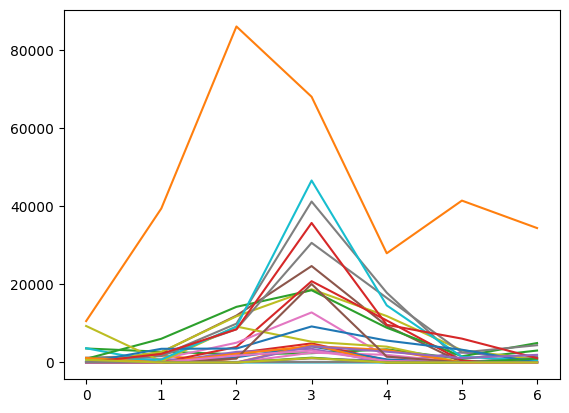

In [485]:
xic_observed = spectrum_slice[0].sum(axis=(1, 2)) ## this gives us mz info and rt info
## this gives intensities for every m/z and RT scan
for i in range(xic_observed.shape[0]):
    plt.plot(xic_observed[i])
plt.show()

In [402]:
#df_obs_corr.query('intensity==0')

In [349]:
from mirror_plotting import convert_library_to_df, split_dense_byRT

In [353]:
df_library = convert_library_to_df(mz_library, intensity_library)
df_obs = split_dense_byRT(spectrum_slice, mz_library, fragment_library)
    

In [355]:
df_library.head(2)

,mz,intensity,norm_intensity
0,175.118958,0.023882,0.023882
1,245.076813,0.187238,0.187238


In [357]:
df_obs.head(2)

,mz,frag_label,intensity,rt_idx,rt_cat,norm_intensity
0,175.118958,y1(+1),2471.834229,0,0,0.010927
1,175.118958,y1(+1),2019.656006,1,1,0.008928


In [361]:
df_merged.head(3)

,mz,intensity_pred,norm_intensity_pred,frag_label,intensity_obs,rt_idx,rt_cat,norm_intensity_obs
0,175.118958,0.023882,0.023882,y1(+1),2471.834229,0,0,0.010927
1,175.118958,0.023882,0.023882,y1(+1),2019.656006,1,1,0.008928
2,175.118958,0.023882,0.023882,y1(+1),4477.133789,2,2,0.019792


In [363]:
df_merged.shape, df_obs.shape

((98, 8), (98, 6))

In [389]:
df_obs_corr.head(10)

,mz,frag_label,intensity,rt_idx,rt_cat,norm_intensity,corr_coeff,rt_cat_corr
0,175.118958,y1(+1),2471.834229,0,0,0.010927,0.426878,"0, r=0.43"
1,175.118958,y1(+1),2019.656006,1,1,0.008928,0.885258,"1, r=0.89"
2,175.118958,y1(+1),4477.133789,2,2,0.019792,0.975294,"2, r=0.98"
3,175.118958,y1(+1),3511.720459,3,3,0.015524,0.972068,"3, r=0.97"
4,175.118958,y1(+1),6634.502930,4,4,0.029329,0.970470,"4, r=0.97"
5,175.118958,y1(+1),5196.434082,5,5,0.022972,0.861296,"5, r=0.86"
6,175.118958,y1(+1),3828.266113,6,6,0.016924,0.886731,"6, r=0.89"
7,245.076813,,0.000000,0,0,0.000000,0.426878,"0, r=0.43"
8,245.076813,b2(+1),2979.795654,1,1,0.013173,0.885258,"1, r=0.89"
9,245.076813,b2(+1),15726.689453,2,2,0.069523,0.975294,"2, r=0.98"


In [383]:
df_obs_corr

,mz,frag_label,intensity,rt_idx,rt_cat,norm_intensity,corr_coeff
0,175.118958,y1(+1),2471.834229,0,0,0.010927,0.426878
1,175.118958,y1(+1),2019.656006,1,1,0.008928,0.885258
2,175.118958,y1(+1),4477.133789,2,2,0.019792,0.975294
3,175.118958,y1(+1),3511.720459,3,3,0.015524,0.972068
4,175.118958,y1(+1),6634.502930,4,4,0.029329,0.970470
...,...,...,...,...,...,...,...
93,1018.534973,y9(+1),1843.444580,2,2,0.008149,0.975294
94,1018.534973,,0.000000,3,3,0.000000,0.972068
95,1018.534973,y9(+1),669.447144,4,4,0.002959,0.970470
96,1018.534973,y9(+1),1606.299805,5,5,0.007101,0.861296


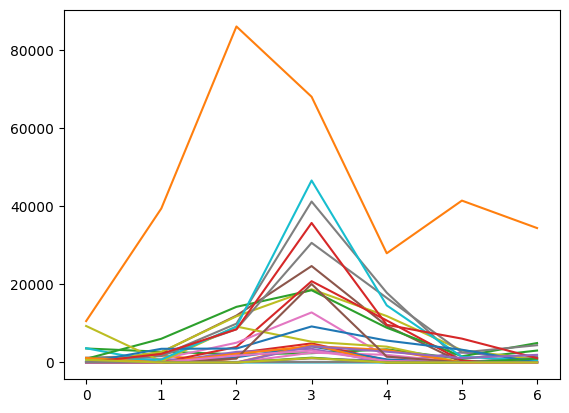

In [429]:
plot_simple_xic(spectrum_slice)

#### 4 Visualize precursor data

Now, we want to viosualize the retrieved spectrum data.
We will start by visualizing the observed spectrum and the library spectrum.

The spectrum data `dense` is a 5 dimensional numpy array with a dense slice of the spectrum space.
The dimensions are:
- 0: either intensity information 0 or relative mass error 1
- 1: index of the fragment mz which was queried
- 2: ion mobility dimension (will be zero for DIA data)
- 3: The observations in the DIA cycle. As there might be multiple quadrupole windows where the precursor was detected, this will be a list of observations.
- 4: Retention time datapoints.

First we will select the intensity dimension and sum over all other dimensions but the fragment mz dimension.


In [61]:
from mirror_plotting import plot_mirror_byRT, split_dense_byRT

In [63]:
#df_obs = split_dense_byRT(dense, mz_library, label_library)
#df_obs

In [184]:
plot_mirror_byRT(dense, mz_library, intensity_library, label_library, width=700, height=300)

7


alt.LayerChart(...)

In [176]:
#from mirror_plotting import get_palette_for_RT
#sns.color_palette(get_palette_for_RT(7))

[(0.0, 1.0, 0.0),
 (0.7176470588235294, 0.2784313725490196, 0.0),
 (0.8823529411764706, 0.11372549019607843, 0.0),
 (1.0, 0.0, 0.0),
 (1.0, 0.6588235294117647, 0.0),
 (1.0, 0.8117647058823529, 0.0),
 (1.0, 0.9137254901960784, 0.0)]

Finally, we will visualize the Precusor ion chromatogram.
We will again select the intensity dimension and sum over ion mobility and observation but leave the retention time dimension.


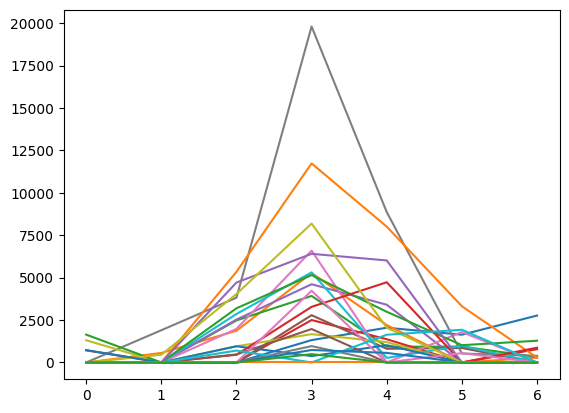

In [48]:
xic_observed = dense[0].sum(axis=(1,2))
for i in range(xic_observed.shape[0]):
    plt.plot(xic_observed[i])
plt.show()